## 10-5　類似文章検索

In [1]:
# !mkdir chap10
%cd ./chap10

/content/chap10


In [2]:
# !pip install transformers==4.18.0 fugashi===1.1.0 ipadic==1.0.0 pytorch-lightning==1.6.1

In [3]:
import glob
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel

In [4]:
MODEL_NAME = 'tohoku-nlp/bert-base-japanese-whole-word-masking'

In [5]:
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar -zxf ldcc-20140209.tar.gz

--2024-05-31 07:49:07--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz.1’

ldcc-20140209.tar.g 100%[===================>]   8.44M   230KB/s    in 26s     

2024-05-31 07:49:33 (333 KB/s) - ‘ldcc-20140209.tar.gz.1’ saved [8855190/8855190]



In [6]:
category_list = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]

tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model = model.cuda()

max_length = 256
sentence_vectors = []
labels = []

for label, category in enumerate(tqdm(category_list)):
  for file in glob.glob(f'./text/{category}/{category}*'):
    lines = open(file).read().splitlines()
    text = '\n'.join(lines[3:])
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
        )

    encoding = {k: v.cuda() for k, v in encoding.items()}
    attention_mask = encoding['attention_mask']

    with torch.no_grad():
      output = model(**encoding)
      last_hidden_state = output.last_hidden_state
      averaged_hidden_state = (last_hidden_state*attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)

    sentence_vectors.append(averaged_hidden_state[0].cpu().numpy())
    labels.append(label)

sentence_vectors = np.vstack(sentence_vectors)
labels = np.array(labels)

Some weights of the model checkpoint at tohoku-nlp/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 9/9 [02:29<00:00, 16.61s/it]


`.unsqueeze(n)` で、テンソルに n 番目の次元を新しく追加する。

In [7]:
sample = [[1, 2], [3, 4]]
print(sample)
sample = np.vstack(sample)
print(sample)

[[1, 2], [3, 4]]
[[1 2]
 [3 4]]


In [8]:
sentence_vectors_pca = PCA(n_components=2).fit_transform(sentence_vectors)
print(sentence_vectors_pca.shape)

(7367, 2)


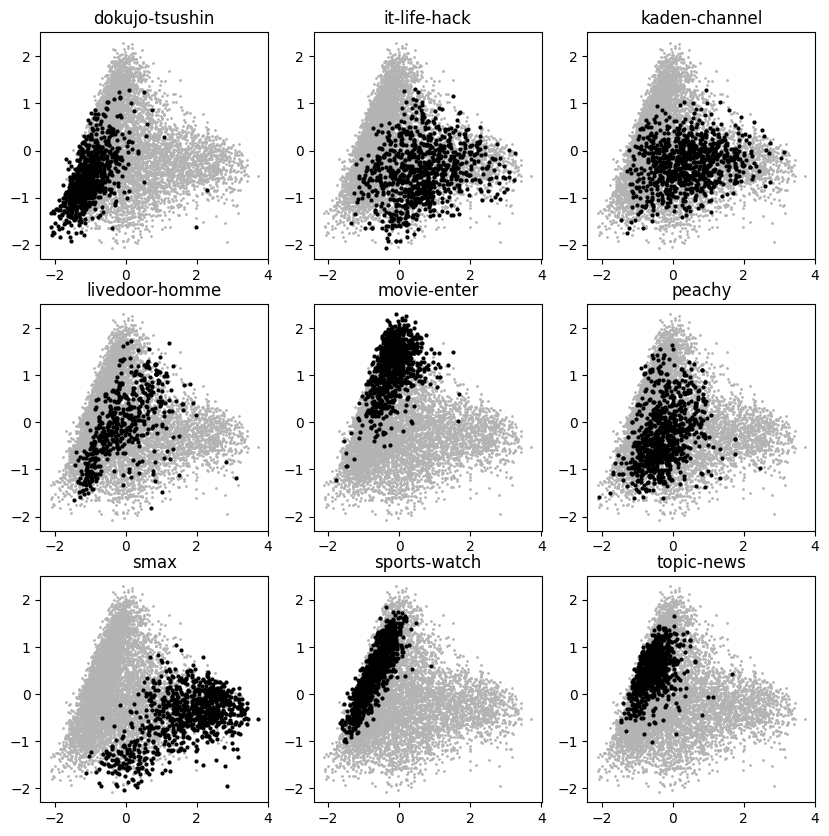

In [9]:
plt.figure(figsize=(10, 10))
for label in range(9):
  plt.subplot(3, 3, label+1)
  index = (labels==label)

  plt.plot(sentence_vectors_pca[:, 0], sentence_vectors_pca[:, 1], 'o', markersize=1, color=[0.7, 0.7, 0.7])
  plt.plot(sentence_vectors_pca[index, 0], sentence_vectors_pca[index, 1], 'o', markersize=2, color='k')
  plt.title(category_list[label])

In [10]:
sentence_vectors_tsne = TSNE(n_components=2).fit_transform(sentence_vectors)

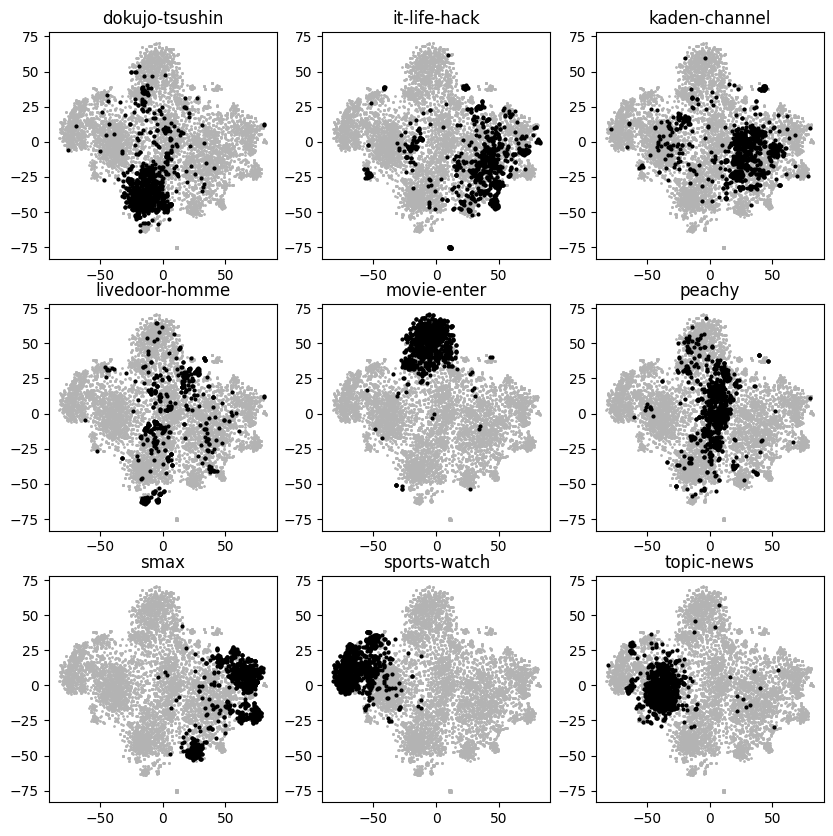

In [11]:
plt.figure(figsize=(10, 10))
for label in range(9):
  plt.subplot(3, 3, label+1)
  index = (labels==label)

  plt.plot(sentence_vectors_tsne[:, 0], sentence_vectors_tsne[:, 1], 'o', markersize=1, color=[0.7, 0.7, 0.7])
  plt.plot(sentence_vectors_tsne[index, 0], sentence_vectors_tsne[index, 1], 'o', markersize=2, color='k')
  plt.title(category_list[label])

In [12]:
norm = np.linalg.norm(sentence_vectors, axis=1, keepdims=True)
sentence_vectors_normalized = sentence_vectors / norm

sim_matrix = sentence_vectors_normalized.dot(sentence_vectors_normalized.T)
np.fill_diagonal(sim_matrix, -1)
similar_news = sim_matrix.argmax(axis=1)

input_news_categories = labels
output_news_categories = labels[similar_news]
num_correct = (input_news_categories == output_news_categories).sum()
accuracy = num_correct / labels.shape[0]

print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.83


内積計算のために `.T` で行列の形状を調整している。

In [13]:
matrix = np.array([[1, 2], [3, 4]])
norm = np.linalg.norm(matrix, axis=1, keepdims=True)
print(norm)

[[2.23606798]
 [5.        ]]
